In [12]:
%matplotlib inline

In [50]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
np.random.seed(42)

d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15

sns.set_palette(sns.color_palette('PuBu'))

Number of atoms: 14
Number of bonds: 15


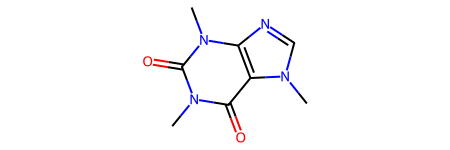

In [63]:
# SMILES representation of a molecule (e.g., caffeine)
smiles_string = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# Create an RDKit molecule object
mol = Chem.MolFromSmiles(smiles_string)

# Display basic information about the molecule
print("Number of atoms:", mol.GetNumAtoms())
print("Number of bonds:", mol.GetNumBonds())

# RDKit molecule objected can be directly viewed in Jupyter
mol

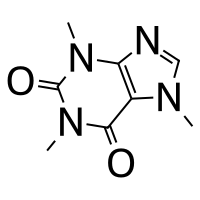

In [64]:
# Alternatively, we can save the RDKit molecule object as an image for later use
img = Draw.MolsToGridImage(
    mols=[mol], molsPerRow=1, useSVG=True, drawOptions=dopts,
)
img

In [66]:
with open("figures/ch01/caffeine.svg", "w") as f:
  f.write(img.data)

In [31]:
usan_stems = ['-caine', '-cillin', '-conazole', '-olol', '-oxacin', '-pine', 'sulfa-', '-terol', '-tinib', '-vir']
dfs = []
for usan_stem in usan_stems:
    df = pd.read_csv(
        f'data/fda_approved_drugs/{usan_stem}.csv',
        sep=';',
        usecols=['Name', 'Smiles', '#RO5 Violations (Lipinski)'],
    )
    df['USAN Stem'] = usan_stem
    dfs.append(df)

In [51]:
fda_approved_df = pd.concat(dfs)

In [67]:
fda_approved_df.to_csv('data/fda_approved_drugs/fda_approved_drugs.csv', sep=',')

In [68]:
fda_approved_df = pd.read_csv('data/fda_approved_drugs/fda_approved_drugs.csv', sep=',')

In [69]:
PandasTools.AddMoleculeColumnToFrame(fda_approved_df, smilesCol='Smiles', molCol='ROMol')

In [70]:
fda_approved_df.head()

,Unnamed: 0,Name,#RO5 Violations (Lipinski),Smiles,USAN Stem,ROMol,ECFP6
0,0,ARTICAINE HYDROCHLORIDE,0,CCCNC(C)C(=O)Nc1c(C)csc1C(=O)OC.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x7f6ed59efc30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
1,1,ETIDOCAINE HYDROCHLORIDE,0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x7f6ed59efbc0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
2,2,ROPIVACAINE HYDROCHLORIDE,0,CCCN1CCCC[C@H]1C(=O)Nc1c(C)cccc1C.Cl,-caine,<rdkit.Chem.rdchem.Mol object at 0x7f6ed59efb50>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
3,3,PROCAINE,0,CCN(CC)CCOC(=O)c1ccc(N)cc1,-caine,<rdkit.Chem.rdchem.Mol object at 0x7f6ed59efae0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
4,4,DIBUCAINE,0,CCCCOc1cc(C(=O)NCCN(CC)CC)c2ccccc2n1,-caine,<rdkit.Chem.rdchem.Mol object at 0x7f6ed59efa70>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...


In [71]:
fda_approved_df = fda_approved_df[~fda_approved_df['ROMol'].isnull()]

In [72]:
fda_approved_df['ECFP6'] = fda_approved_df['ROMol'].apply(AllChem.GetMorganFingerprintAsBitVect, radius=3, nBits=1024)

In [73]:
fda_approved_df.groupby('USAN Stem').size().sort_values()

USAN Stem
-pine        22
sulfa-       23
-conazole    24
-oxacin      29
-terol       29
-caine       33
-olol        37
-vir         40
-cillin      46
-tinib       60
dtype: int64

In [58]:
sample_drugs = pd.concat(
    [
        fda_approved_df[fda_approved_df['USAN Stem'] == usan_stem].head(2) 
        for usan_stem in usan_stems
    ]
)

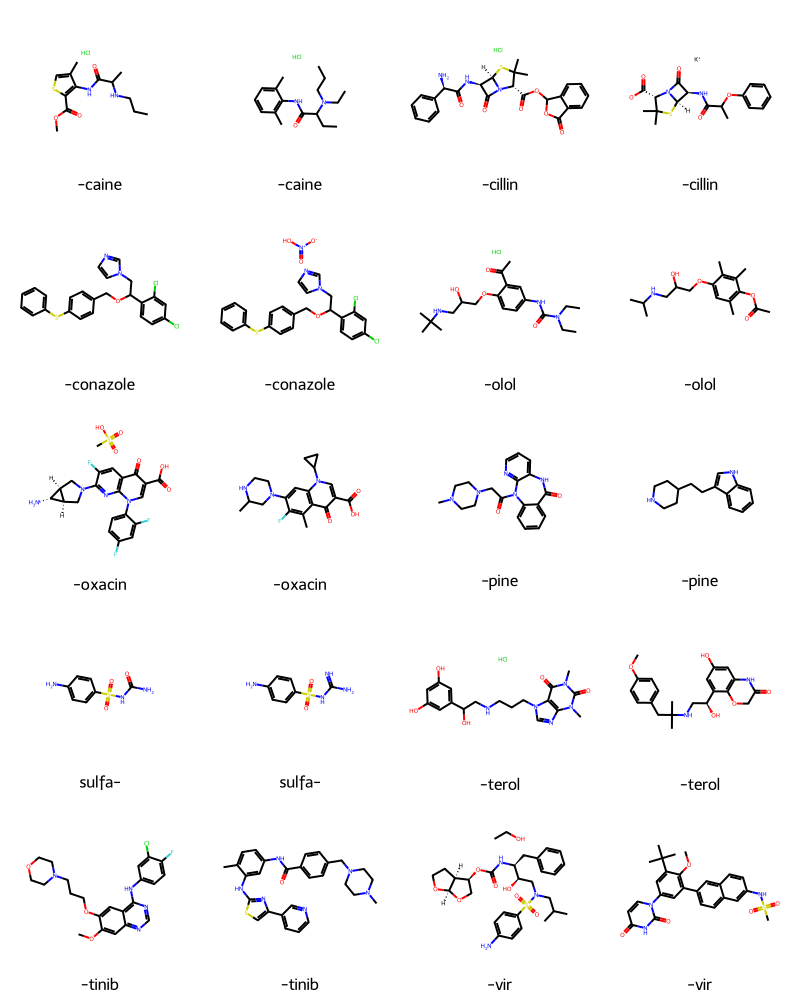

In [59]:
PandasTools.FrameToGridImage(sample_drugs, legendsCol='USAN Stem', molsPerRow=4)

## Supervised Learning Example

Goal: Binary classification for one of the USAN classes. Can then also compare the misclassification rate of false positives for the true USAN class across the other USAN classes

## Unsupervised Learning Example

In [74]:
from sklearn.decomposition import PCA

In [78]:
X = np.array([x for x in fda_approved_df['ECFP6']])

In [97]:
pca = PCA(n_components=4, random_state=42)
pca_drugs = pca.fit_transform(X)

In [98]:
fda_approved_df['PC1'] = pca_drugs.T[0]
fda_approved_df['PC2'] = pca_drugs.T[1]
fda_approved_df['PC3'] = pca_drugs.T[2]
fda_approved_df['PC4'] = pca_drugs.T[3]

<Figure size 640x480 with 0 Axes>

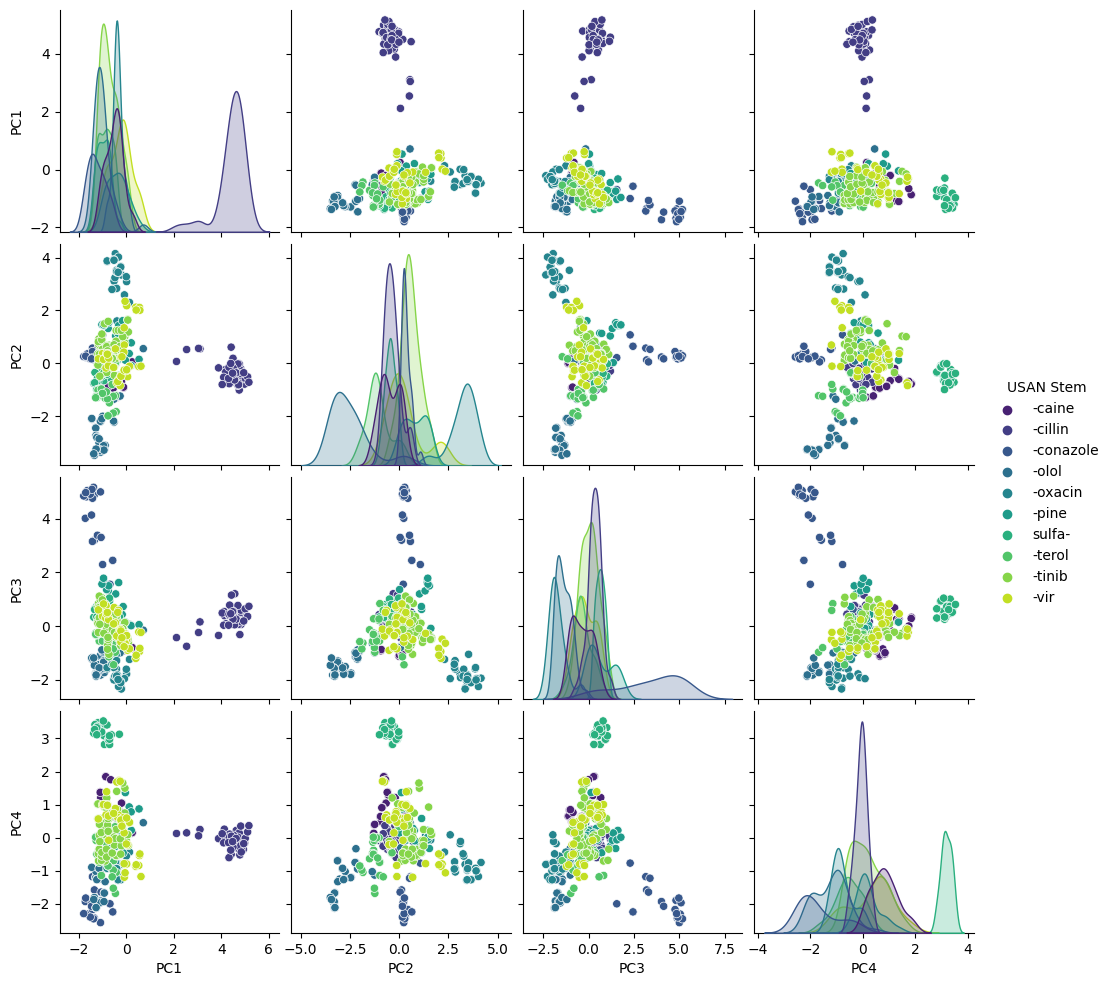

In [101]:
plt.figure()
sns.pairplot(fda_approved_df, hue='USAN Stem', vars=['PC1', 'PC2', 'PC3', 'PC4'], palette='viridis')
#plt.tight_layout()
plt.savefig('figures/ch01/pca_pairplot.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch01/pca_pairplot.svg', bbox_inches='tight', dpi=600);

In [133]:
fda_approved_df['cillin'] = (fda_approved_df['USAN Stem'] == '-cillin').astype(int)
fda_approved_df['olol'] = (fda_approved_df['USAN Stem'] == '-olol').astype(int)

In [134]:
from sklearn.linear_model import LogisticRegression

lr_model_cillin = LogisticRegression()
lr_model_cillin.fit(fda_approved_df[['PC1', 'PC3']], fda_approved_df.cillin)

xx, yy = np.mgrid[fda_approved_df.PC1.min():fda_approved_df.PC1.max():.01, fda_approved_df.PC3.min():fda_approved_df.PC3.max():.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = lr_model_cillin.predict_proba(grid)[:, 1].reshape(xx.shape)

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


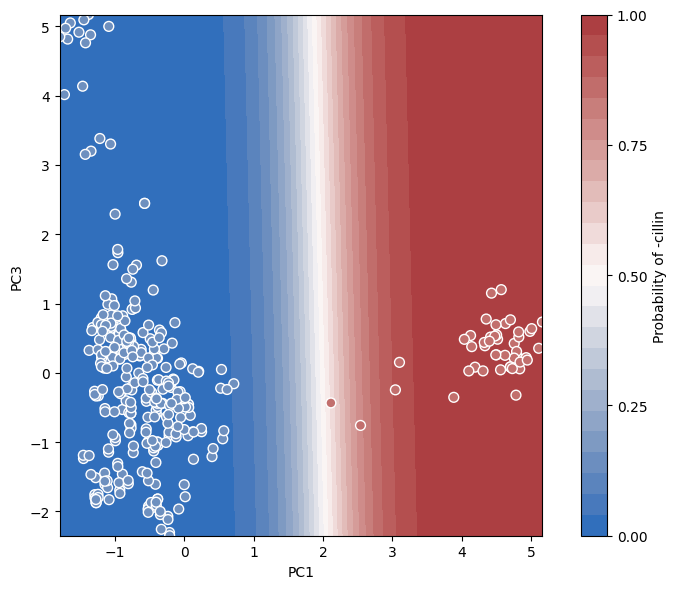

In [138]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="vlag", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("Probability of -cillin")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(fda_approved_df.PC1, fda_approved_df.PC3, c=fda_approved_df.cillin, s=50,
           cmap="vlag", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal", xlim=(fda_approved_df.PC1.min(), fda_approved_df.PC1.max()), ylim=(fda_approved_df.PC3.min(), fda_approved_df.PC3.max()), xlabel="PC1", ylabel="PC3")

f.tight_layout()
f.savefig('figures/ch01/cillin_decision_boundary.png', bbox_inches='tight', dpi=600)
f.savefig('figures/ch01/cillin_decision_boundary.svg', bbox_inches='tight', dpi=600);

In [139]:
lr_model_olol = LogisticRegression()
lr_model_olol.fit(fda_approved_df[['PC1', 'PC3']], fda_approved_df.olol)

xx, yy = np.mgrid[fda_approved_df.PC1.min():fda_approved_df.PC1.max():.01, fda_approved_df.PC3.min():fda_approved_df.PC3.max():.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = lr_model_olol.predict_proba(grid)[:, 1].reshape(xx.shape)

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


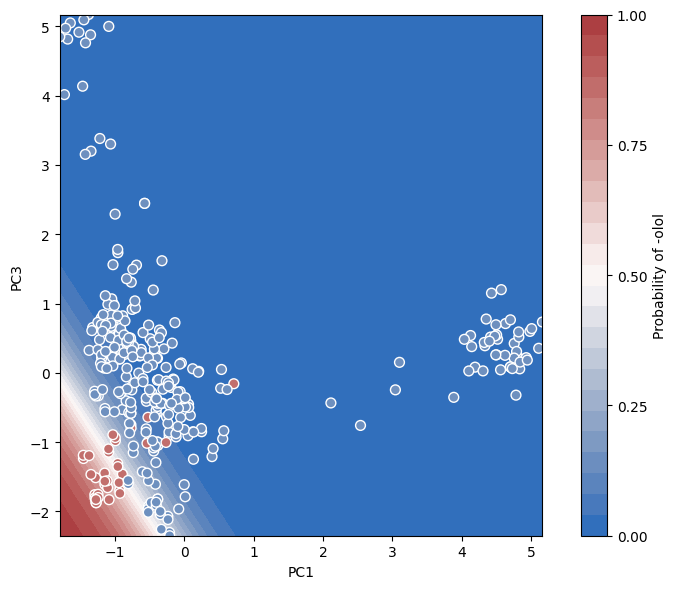

In [140]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="vlag", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("Probability of -olol")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(fda_approved_df.PC1, fda_approved_df.PC3, c=fda_approved_df.olol, s=50,
           cmap="vlag", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal", xlim=(fda_approved_df.PC1.min(), fda_approved_df.PC1.max()), ylim=(fda_approved_df.PC3.min(), fda_approved_df.PC3.max()), xlabel="PC1", ylabel="PC3")

f.tight_layout()
f.savefig('figures/ch01/olol_decision_boundary.png', bbox_inches='tight', dpi=600)
f.savefig('figures/ch01/olol_decision_boundary.svg', bbox_inches='tight', dpi=600);